# Отток клиентов

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Описание данных

- Признаки
 - RowNumber — индекс строки в данных
 - CustomerId — уникальный идентификатор клиента
 - Surname — фамилия
 - CreditScore — кредитный рейтинг
 - Geography — страна проживания
 - Gender — пол
 - Age — возраст
 - Tenure — количество недвижимости у клиента
 - Balance — баланс на счёте
 - NumOfProducts — количество продуктов банка, используемых клиентом
 - HasCrCard — наличие кредитной карты
 - IsActiveMember — активность клиента
 - EstimatedSalary — предполагаемая зарплата
- Целевой признак
 - Exited — факт ухода клиента

# Подготовка данных

In [32]:
#Импортируем библиотеки
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report

from scipy.stats import randint
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings("ignore") 
from sklearn.preprocessing import StandardScaler
import seaborn as sns 
from sklearn.utils import shuffle

In [9]:
#откроем файл с данными
data_start = pd.read_csv('/home/andrey/Datasets//Churn.csv')
print(data_start.info())
data_start.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB
None


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


0    7963
1    2037
Name: Exited, dtype: int64

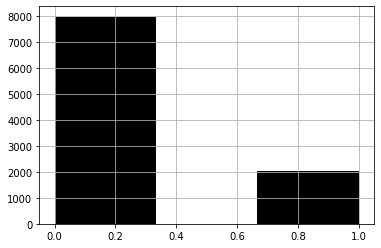

In [10]:
#Сравним соотношение ушедших/оставшихся клиентов в датасете
data_start['Exited'].hist(bins = 3, color=('black'))
data_start['Exited'].value_counts()

Соотношение оставшихся к ушедшим 4к1 соответственно.

- Необходимо обработать пропуски в столбце Tenure.

- Столбцы RowNumber, CustomerId, Surname не понадобятся их можно убрать, так как навряд ли присутсвует связь между внутренним номером клиента банка, его именем и уходом из банка.

- Категориальные признаки в столбцах Geography, Gender приведём в численные техникой OHE.

In [11]:
#удалим столбцы.
data_start = data_start.drop(['RowNumber','CustomerId','Surname'],axis=1)

In [12]:
#заполним пропуски в столбце Tenure
data_start['Tenure'] = data_start.groupby(['Age','Geography','Gender'])['Tenure'].transform(
    lambda x: x.fillna(x.mean())).fillna(0).astype(int)

In [16]:
#категориальные признаки в столбцах Geography, Gender приведём в численные техникой OHE.
data_ohe = pd.get_dummies(data_start, drop_first=True)

In [17]:
#разделим данные на обучающую, валидационную и тестовую выборки.
y = data_ohe['Exited']
X = data_ohe.drop('Exited', axis=1)
X_train, X_test,y_train, y_test = train_test_split(
    features, target, test_size=0.25, random_state=12345)

# Исследование задачи

- Исследуем баланс классов.

In [21]:
#масштабируем признаки для регрессии
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary',]

scaler = StandardScaler()
scaler.fit(features_train[numeric])

X_train_reg = X_train.copy(deep=True)
X_test_reg = X_test.copy(deep=True)

X_train_reg[numeric] = scaler.transform(X_train[numeric])
X_test_reg[numeric] = scaler.transform(X_test[numeric])

In [27]:
%%time
#logistic regression
model = LogisticRegression(random_state=12345)

param = {"class_weight" : ['balanced', None],
         "penalty" : ["l1", "l2", "elasticnet", "None"],
         "solver" : ["liblinear", "lbfgs"]
        }

model_rscv = RandomizedSearchCV(model, param_distributions = param, scoring = "f1",
                             cv = 3, verbose = 0, random_state = 12345, n_jobs = -1, n_iter = 100)

model_lr = model_rscv.fit(X_train_reg, y_train)

print("Лучшие гиперпараметры для модели логистической регрессии")
print()
print(model_lr.best_estimator_.get_params())

pred = model_lr.predict(X_test_reg)
print()
print("f1 = {}".format(f1_score(y_test, pred)))

probabilities_valid = model_lr.predict_proba(X_test_reg)
probabilities_one_valid = probabilities_valid[:, 1]



Лучшие гиперпараметры для модели логистической регрессии

{'C': 1.0, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 12345, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}

f1 = 0.5030100334448161
CPU times: user 109 ms, sys: 9 ms, total: 118 ms
Wall time: 138 ms


Построим ROC-график. Для построения используем функцию roc_curve.

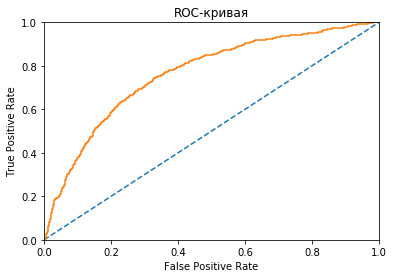

In [28]:
def rocCurve(y_test, probabilities_one_valid):
    fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_valid)

    plt.figure()
    # ROC-кривая случайной модели (выглядит как прямая)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.show()
rocCurve(y_test, probabilities_one_valid)

In [30]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.90      0.70      0.79      1965
           1       0.39      0.70      0.50       535

    accuracy                           0.70      2500
   macro avg       0.64      0.70      0.65      2500
weighted avg       0.79      0.70      0.73      2500



- Из таблицы видно что f1 для 0 и 1 существенно различается. 
- По графику видно, что модель существенно лучше чем случайная. Рассчитаем AUC-ROC для более точного понимания различия.

In [31]:
print(f"AUC-ROC = {roc_auc_score(y_test, probabilities_one_valid)}")

AUC-ROC = 0.7629212147154645


Лучшие гиперпараметры для модели случайного леса

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 11, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 5, 'min_samples_split': 8, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 3814, 'n_jobs': None, 'oob_score': False, 'random_state': 12345, 'verbose': 0, 'warm_start': False}

F1 = 0.6481149012567324


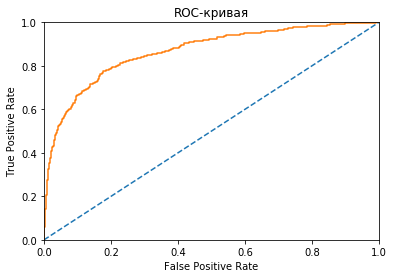

              precision    recall  f1-score   support

           0       0.91      0.89      0.90      1965
           1       0.62      0.67      0.65       535

    accuracy                           0.84      2500
   macro avg       0.77      0.78      0.77      2500
weighted avg       0.85      0.84      0.85      2500

CPU times: user 21.9 s, sys: 241 ms, total: 22.1 s
Wall time: 2min 34s


In [36]:
%%time
#random_forest
model = RandomForestClassifier(random_state = 12345)

#подберём гиперпараметры с помощью RandomizedSearchCV
param = {"max_depth": [3, 4, 5, 6, 7, 8, 9, 11, 13, 15, 17, 19, 21],
         "n_estimators" : randint(500, 4000),
         "min_samples_split" : randint(1,10),
         "min_samples_leaf": randint(1, 9),
         "criterion": ["gini", "entropy"],
        "class_weight" : ["balanced", None]}

model_rscv = RandomizedSearchCV(model, param_distributions = param, scoring = "f1",
                             cv = 2, verbose = 0, random_state = 12345, n_jobs = -1, n_iter = 100)

model_forest = model_rscv.fit(X_train, y_train)

print("Лучшие гиперпараметры для модели случайного леса")
print()
print(model_forest.best_estimator_.get_params())

pred = model_forest.predict(X_test)
print()
print("F1 = {}".format(f1_score(y_test, pred)))

probabilities_valid = model_forest.predict_proba(X_test)
probabilities_one_valid = probabilities_valid[:, 1]
rocCurve(y_test, probabilities_one_valid)
print(classification_report(y_test, pred))

Без учёта дисбаланса, в датасете лучше всего себя показала модель random forest,  будем использовать её для дальнейшей работы.

# Борьба с дисбалансом

- Создадим функцию для umpsampling

In [37]:
def upsample(X, y, repeat):
    X_zeros = X[target == 0]
    X_ones = X[target == 1]
    y_zeros = y[target == 0]
    y_ones = y[target == 1]

    X_upsampled = pd.concat([X_zeros] + [X_ones] * repeat)
    y_upsampled = pd.concat([y_zeros] + [y_ones] * repeat)
    
    X_upsampled, y_upsampled = shuffle(
        X_upsampled, y_upsampled, random_state=12345)
    
    return X_upsampled, y_upsampled

- Обучим модель случайного леса с апсемплингом и подбором гиперпареметров.

Лучшие гиперпараметры для модели случайного леса

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 15, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 310, 'n_jobs': None, 'oob_score': False, 'random_state': 12345, 'verbose': 0, 'warm_start': False}

F1 = 0.9070567986230637


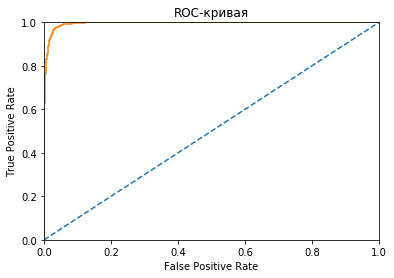

              precision    recall  f1-score   support

           0       1.00      0.95      0.97      1965
           1       0.84      0.99      0.91       535

    accuracy                           0.96      2500
   macro avg       0.92      0.97      0.94      2500
weighted avg       0.96      0.96      0.96      2500

CPU times: user 3.94 s, sys: 60.1 ms, total: 4 s
Wall time: 11.2 s


In [44]:
%%time
#random_forest
model = RandomForestClassifier(random_state = 12345)

#подберём гиперпараметры с помощью RandomizedSearchCV
param = {"max_depth": [3, 4, 5, 6, 7, 8, 9, 11, 13, 15, 17, 19, 21],
         "n_estimators" : randint(100, 500),
         "min_samples_split" : randint(1,10),
         "min_samples_leaf": randint(1, 9),
         "criterion": ["gini", "entropy"],
        "class_weight" : ["balanced", None]}

model_rscv = RandomizedSearchCV(model, param_distributions = param, scoring = "f1",
                             cv = 4, verbose = 0, random_state = 12345, n_jobs = -1, n_iter = 10)

X_train, y_train = upsample(X, y, 4)

model_forest = model_rscv.fit(X_train, y_train)

print("Лучшие гиперпараметры для модели случайного леса")
print()
print(model_forest.best_estimator_.get_params())

pred = model_forest.predict(X_test)
print()
print("F1 = {}".format(f1_score(y_test, pred)))

probabilities_valid = model_forest.predict_proba(X_test)
probabilities_one_valid = probabilities_valid[:, 1]
rocCurve(y_test, probabilities_one_valid)
print(classification_report(y_test, pred))

Random forest с приминением upsampling показал лучший результат по метрике f1.

# Вывод

- f1 мера на тестовой выборке показала значение 0.9070567986230637.

- Модель была протеститрована на тестовой выборке и полученные значения метрик удовлетворяют требуемым.